In [1]:
import os
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
geo_limits_path = "Data/Geo_Limits.htm"

In [3]:
def check_geo_limits_path():
    # Define the relative path from the root folder
    geo_limits_path = os.path.join(os.getcwd(), "Data", "Geo_Limits.htm")
    
    # Check if the file exists
    if os.path.isfile(geo_limits_path):
        print(f"File found: {geo_limits_path}")
        return True
    else:
        print(f"File not found: {geo_limits_path}")
        return False

In [4]:
check_geo_limits_path()

File found: c:\Users\haoch\Desktop\GEO-bot-prototype\playground\Data\Geo_Limits.htm


True

In [5]:
def extract_entities_from_html(file_path):
    """
    Extracts categories and their limits from the GEO_Limits HTML file.
    """
    entities = {}
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')

            # Find all tables in the document
            tables = soup.find_all('table')

            current_category = None

            for table in tables:
                rows = table.find_all('tr')

                for row in rows:
                    cols = row.find_all('td')
                    cols = [col.get_text(strip=True) for col in cols]

                    # Identify category headers (bold text or appearing as titles)
                    if len(cols) == 2 and cols[0] and not cols[1]:
                        current_category = cols[0].strip()
                        entities[current_category] = []
                    elif current_category:
                        # Add the attribute and its limit to the current category
                        if len(cols) == 2 and cols[0] and cols[1]:
                            attribute, limit = cols
                            entities[current_category].append((attribute, limit))

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return entities

In [6]:
entities = extract_entities_from_html(geo_limits_path)

In [7]:
def build_knowledge_graph(entities):
    """
    Constructs a knowledge graph from extracted entities.
    """
    graph = nx.Graph()

    for category, attributes in entities.items():
        graph.add_node(category, label='Category')
        for attribute, limit in attributes:
            graph.add_node(attribute, label='Attribute')
            graph.add_edge(category, attribute, label=f'Limit: {limit}')

    return graph

In [8]:
knowledge_graph = build_knowledge_graph(entities)

In [9]:
def visualize_graph(graph):
    """
    Visualizes the knowledge graph using NetworkX.
    """
    plt.figure(figsize=(18, 18))
    pos = nx.spring_layout(graph, k=0.8)  # Adjust for spacing
    nx.draw(graph, pos, with_labels=True, node_size=3000, font_size=8, 
            font_weight='bold', node_color='lightblue', edge_color='gray')
    plt.title("Knowledge Graph from GEO_Limits HTML")
    plt.savefig("Outputs/demo-tree-graph.png")
    plt.show()

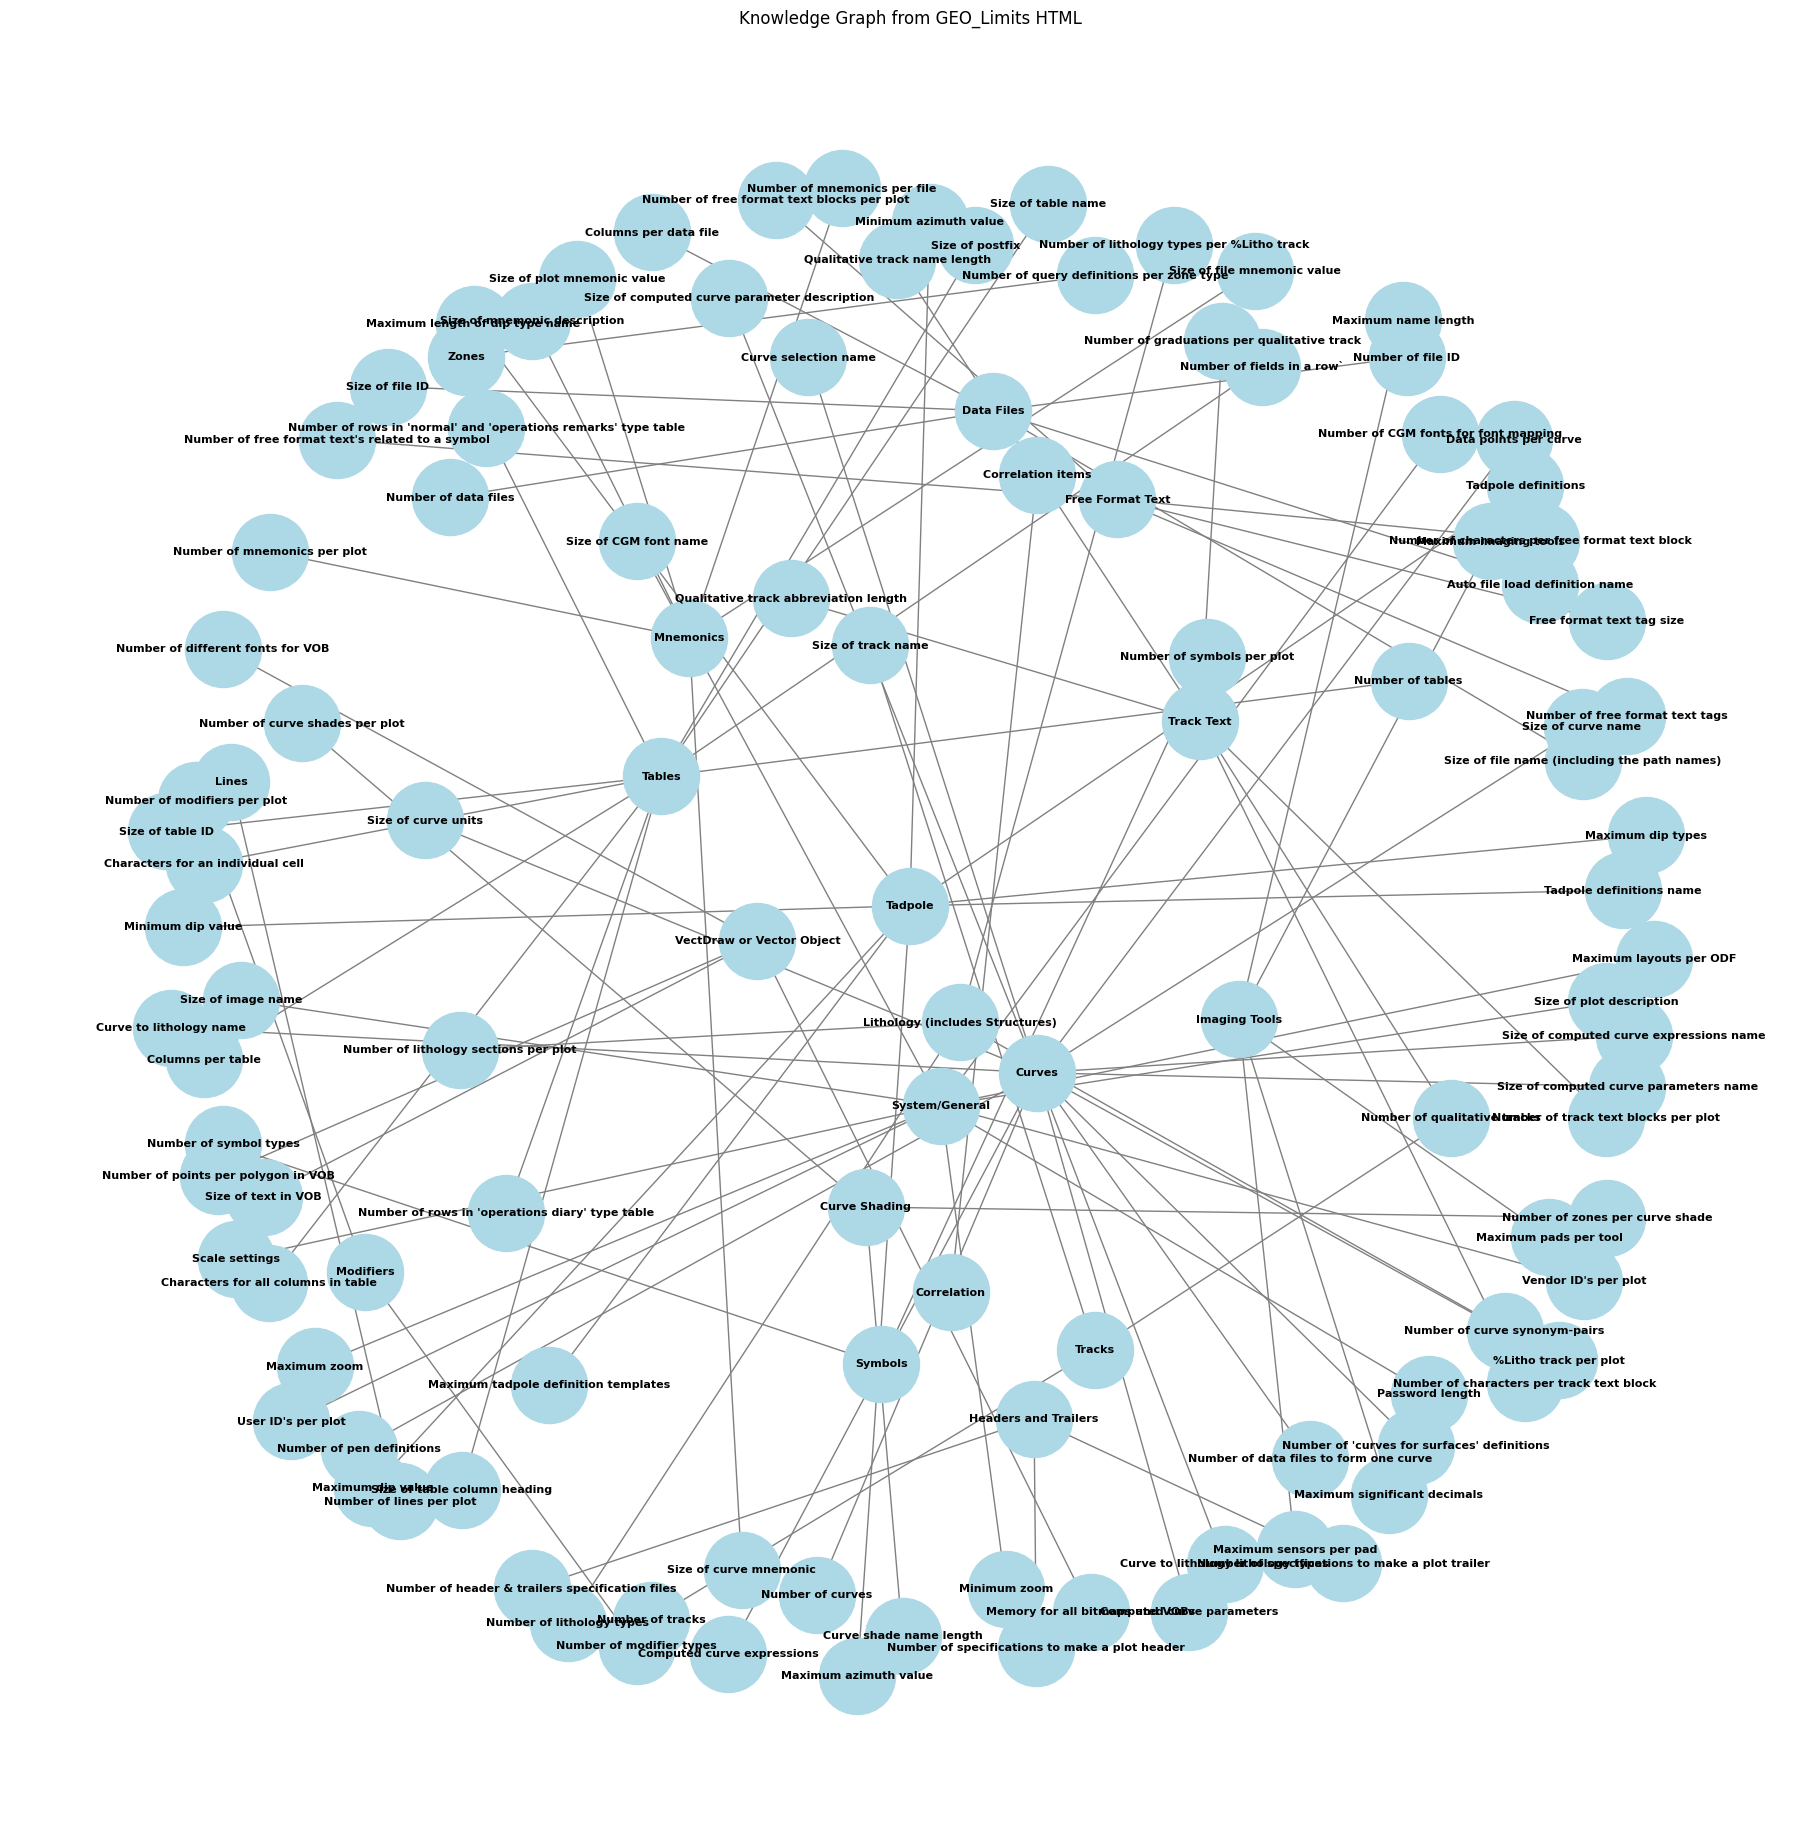

In [10]:
visualize_graph(knowledge_graph)